# Chlorophyll Observations at Seabird Nesting Sites
#### There are seventy listed seabird sites across the globe. We will aggregate the data in a 300km radius of these sites, and plot if necessary.

In [1]:
#load essential packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import geopy.distance

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs

#ignore cartopy style warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# if acquiring for the first time
ds_color = xr.open_dataset('https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v5.0-MONTHLY')

In [2]:
# open CSV of seabird nesting sites
locs = pd.read_csv('NSF_Seabirdsloc_Summer2022.csv')
sites = locs['Site']

In [52]:
# build a mask of 5 degrees circle around first site
print("Finding Region")
firstSite = sites[0]
lat = locs['Latitude'][locs['Site'] == firstSite]
lon = locs['Longitude'][locs['Site'] == firstSite]
lats = [lat-5, lat+5]
lons = [lon-5, lon+5]

# convert to values
lats = [float(i) for i in lats]
lons = [float(i) for i in lons]

# build dataframe to pull from
data = ds_color.copy()

print("Cutting Data")
data = data['chlor_a'].sel(
    time = '2020-06-01',
    lon = slice(lons[0], lons[1]),
    lat = slice(lats[1], lats[0])
).load()

# build mask for all points within geopy.distance.great_circle 300km
print("Creating Mask")
mask = np.zeros(data.shape)
for i in range(data.lon.size):
    for j in range(data.lat.size):
        if geopy.distance.great_circle((data.lat[j].values, data.lon[i].values), (lat.values[0], lon.values[0])).km < 300:
            mask[j,i] = 1

mask

totalInsidePoints = np.sum(mask)

Finding Region
Cutting Data
Creating Mask


In [56]:
def get_chlo_concentration_at_site(site, time, plot=False, roundTo=0):
    """
    Finds the average chlorophyll concentration in a 300km radius around seabird nesting sites
    Author: Austin
    Args:
      <Str> site: the name of the seabird nesting site
      <Str> time: the time of the data to be analyzed
      <Boolean> plot: prints plot
      <Integer> range: the radius of the area to count, in km
      <Integer> roundTo: the number of decimals to round to
    Returns:
      <Float> avgChLevel: the average chlorophyll concentration in the area
    """

    # copy to prevent overwriting
    data = ds_color.copy()

    # get the location of the site
    lon = locs.loc[sites[sites==site].index[0]].Longitude
    lat = locs.loc[sites[sites==site].index[0]].Latitude

    # for each location, select a region +-5 deg, all times
    lats = [float(lat-5), float(lat+5)]
    lons = [float(lon-5), float(lon+5)]

    # select the region with the timestep
    data = data['chlor_a'].sel(
        time = time,
        lon = slice(lons[0], lons[1]),
        lat = slice(lats[1], lats[0])
    ).load()

    # gets the distance between two points of lat,lon in km
    def get_distance(lat1, lon1, lat2, lon2):
        return geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km

    # plot values only that are within 300 units of the (lat, lon)
    sumChLevels = 0;
    totalPointsInRange = 0;
    for i in range(len(data.lat)):
        for j in range(len(data.lon)):
            thisLat = data.lat[i].item()
            thisLon = data.lon[j].item()

            # if the point exists in the mask
            if mask[i,j] == 0:
               data.values[i][j] = np.nan
            else:
                pt = data.values[i][j]
                if (str(pt) == "nan"):
                    continue;
                sumChLevels += data.values[i][j].item()
                totalPointsInRange += 1

    # calculate the average
    if (totalPointsInRange > 0):
        avgChLevel = sumChLevels/totalPointsInRange
    else:
        return "No Data"

    region = np.array([
        [
            data.lat.min().values.item(),
            data.lat.max().values.item()
        ],
        [
            data.lon.min().values.item(),
            data.lon.max().values.item()
        ]
    ]) 

    if (plot == True):
        # Select a region of our data
        fig = plt.figure(figsize=(16,10), dpi = 72)
        ax = plt.axes(projection=ccrs.PlateCarree())

        # Add coastlines
        states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        ax.coastlines(resolution='10m',linewidth=1,color='black')
        ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
        ax.add_feature(states_provinces, linewidth = 0.5)
        ax.add_feature(cfeature.BORDERS, color = 'black')
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        ax.gridlines(linestyle = '--', linewidth = 0.5)

        # Add the data
        plt.title("Seabird Observation Locations")
        ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree())
        data.plot()
        plt.show()

    if ((totalPointsInRange / totalInsidePoints) < 0.2):
        print("Warning: At this timestep, less than 20% of the points are in the 300km radius")
    # round the average to the desired decimal place
    if (roundTo > 0):
        avgChLevel = np.round(avgChLevel, roundTo)
    return avgChLevel

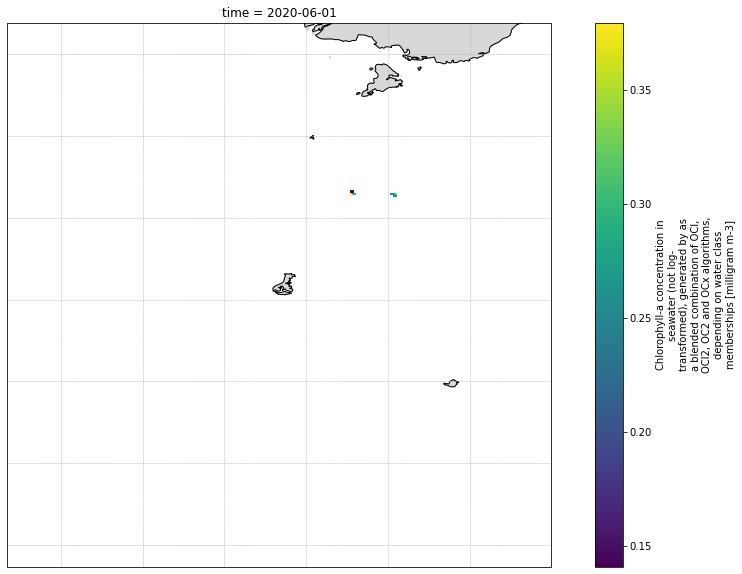

Chlo Concentration at Adams: 0.26


Chlo Concentration at Admiralty: No Data




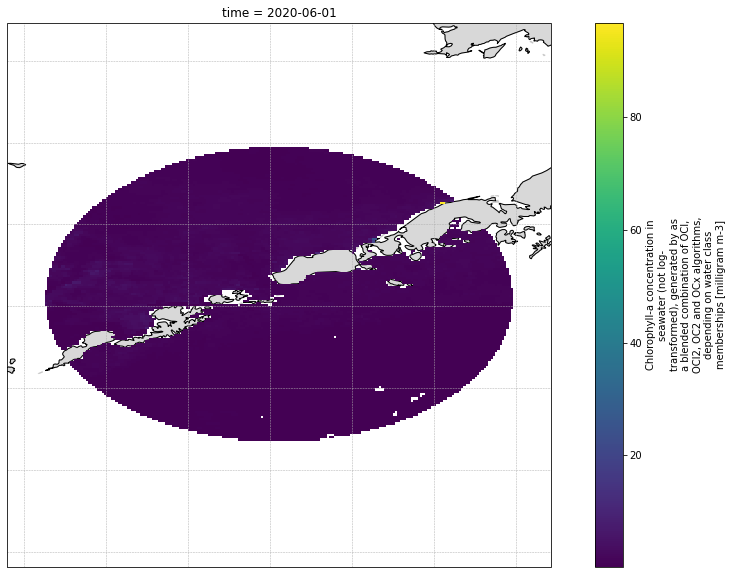

Chlo Concentration at Aiktak: 0.93




In [57]:
"""
Quick example of how to use the function
(This will iterate through each site and graph it)
"""
for x in range(len(sites)):
    print("Chlo Concentration at " + sites[x] + ": " + str(get_chlo_concentration_at_site(sites[x], '2020-06-01', plot=True, roundTo=2)))
    print("\n")

# TODO
1. ~~Use a MASKING method instead of a search-and-destroy method. Use the first generated graph as a mask (sol said 5 degrees is OK) and then apply that mask to every site after, for constructing a dataframe later. Keep the search-and-destroy method available in case it is needed, and document it carefully.~~
2. Construct a dataframe with each site's chlorophyll concentration, as well as the site's name and location, along with the time.
3. Run calculation for one timestep for each site

In [ ]:
# Useful for seeing what timesteps are avilable
ds_color.time

<xarray.DataArray 'time' (time: 292)>
array(['1997-09-04T00:00:00.000000000', '1997-10-01T00:00:00.000000000',
       '1997-11-01T00:00:00.000000000', ..., '2021-10-01T00:00:00.000000000',
       '2021-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2021-12-01
Attributes:
    axis:           T
    standard_name:  time
    _ChunkSizes:    1

In [ ]:
# Example Usage: Find the average chlorophyll level for a specific site
# (and plot the data)
get_chlo_concentration_at_site("Signy", time='2021-12-01', plot=True, roundTo=2)
# Example Usage: Find the average chlorophyll level for every site
print("Site Name: Seawater Chlorophyll Concentration")
for x in range(len(sites)):
    chl = get_chlo_concentration_at_site(sites[x], time='2021-12-01', roundTo=2)
    print(sites[x] + ": " + str(chl))
    
# only count data at sites that have at least half filled circles